# Case 3. Patient Drug Review
**Neural Networks for Machine Learning Applications**<br>
12.03.2023<br>
Erik Holopainen, Alejandro Rosales Rodriguez and Brian van den Berg<br>
[Information Technology, Bachelor's Degree](https://www.metropolia.fi/en/academics/bachelors-degrees/information-technology)<br>
[Metropolia University of Applied Sciences](https://www.metropolia.fi/en)

## 1. Introduction

This notebook serves as an assignment to test our natural text processing skills in regards of Neural Networks. We will have to preprocess and diagnose written texts whether they're negative, neutral and positive. During this assignment we're actually going to work with a dataset containing drug reviews that was used for a hackaton. Hackaton is a competition and we will be using the predefined testing set that the competition provided to the competitors aswell.

## 2. Setup

The data science/machine learning libraries that we imported are:
- tensorflow: Open source library for numerical computation that makes machine learning and developing neural networks faster and easier.
- pandas: Fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.
- numpy: Python library used for working with arrays. It also has functions for working in domain of linear algebra, fourier transform, and matrices.
- nltk: Leading platform for building Python programs to work with human language data.
- sklearn: Simple and efficient tools for predictive data analysis.
- matplotlib.pyplot: Comprehensive library for creating static, animated, and interactive visualizations in Python.

The regular Python libraries we imported are:
- html: Utilities to manipulate HTML.
- re: Regular expression matching operations similar to those found in Perl.
- sys: variables used or maintained by the interpreter and to functions that interact strongly with the interpreter

In [48]:
# Machine Learning and Data Science
import pandas as pd
import numpy as np
import nltk

# Modeling neural networks
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# General imports
import html
import re
import sys

# Print the library versions
print('\033[1m' + 'Notebook Version Register:' + '\033[0m')
print(f'[Python {sys.version}]')
print(f'[{tf.__name__} {tf.__version__}]')
print(f'[{pd.__name__} {pd.__version__}]')
print(f'[{np.__name__} {np.__version__}]')
print(f'[{sklearn.__name__} {sklearn.__version__}]')
print(f'[{nltk.__name__} {nltk.__version__}]')
print(f'[{matplotlib.__name__} {matplotlib.__version__}]')

Notebook Version Register:
[Python 3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]]
[tensorflow 2.11.0]
[pandas 1.5.3]
[numpy 1.24.1]
[sklearn 1.2.0]
[nltk 3.8.1]
[matplotlib 3.6.3]


### Download

By using the function 'nltk.download('popular')' we are checking if the python environment already has access to the nltk datasets. If the datasets are already there, it marks the requirement as satisfied. If the datasets are outdated or if they're not even there, then nltk downloads the resources for you.

In [49]:
# Fetch the nltk datasets
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

True

## 3. Dataset

The dataset consist of a table with a lot of data on user reviews. The idea is that every review is coupled with a drug, condition, rating, date and useful count. The meaning of all of these columns is as follows:
- Drug Name: The name of the drug that the review is about.
- Condition: The condition of the patient that wrote the review.
- Review: The written feedback on the drug.
- Date: The date at which the review was written.
- Useful Count: The amount of people who marked the review as useful.
- Rating: The score that the customer gave from 1 to 10.

During our case studies however, we will only be focussing on one column and that is 'Review', because the assignment was about guessing the Rating based on the Review.

In [50]:
# Load in the dataframe
df = pd.read_csv('input\\drugsComTrain_raw.csv')

# Display the dataframe
display(df)

# Display the dataframe description
print("Description of the dataframe:")
display(df.describe().T)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


Description of the dataframe:


,count,mean,std,min,25%,50%,75%,max
uniqueID,161297.0,115923.585305,67004.445170,2.0,58063.0,115744.0,173776.0,232291.0
rating,161297.0,6.994377,3.272329,1.0,5.0,8.0,10.0,10.0
usefulCount,161297.0,28.004755,36.403742,0.0,6.0,16.0,36.0,1291.0


## 4. Preprocessing

To start describing the general preprocessing questions, the missing values have been deleted, because you can't simulate text entries in a dataframe. Besides the empty reviews, we also deleted the one character reviews, because they were just as useless to the training process. besides this, the data was already stored in the right data types, so there were no conversions.

Splitting was an interesting topic during this case study, because we actually figured out that the training dataset did not represent the testing dataset that well. For this reason, we decided to use a split from the testing data to be used as the validation data. After doing this, the evaluation curves acted like they normally would. Our hypothesis is that because the datasets were created for the hackaton, the input files for the training and testing sets are not representing eachother correcly to be able to use a split from the training data as validation data. When we used the training data for validation, we noticed that the model started overfitting immidiatly, while after training, the testing data reported an 85% accuracy. This was definitly a weird discovery to work with. The actual splits are around [64, 7, 29], which represent [train, val, test].

The features are the reviews, which are encoded as paragraphs of text and the labels are ratings represented as numbers between 1 and 10.

As for the normalization, we had to lemmatize the text, which would be the same as normalization of words. The sentences were also filtered for English stopwords, special characters and numbers. And as a last step, the words were also tokenized to be stored as numbers instead of strings, which needs to be done in able to make it possible for the model to process them. The labels had to be scaled from 1 to 10 to categorical data represented as 0 to 2. 0 being 1 to 4, 1 being 5 and 6 and 2 being 7 to 10. The numbers represent Negative, Neutral and Positive.

### Prepare

Before preprocessing the reviews, we have to filter the data for reviews that aren't useful for training our model. this is done by removing duplicate, empty and one character entries. besides that we are also decoding HTML and removing hashtags within the reviews to better prepare the data.

In [51]:
# Function to remove hashtags from reviews
def remove_hashtags(text):
    return re.sub(r'#\w+', '', text)

# Function to prepare data for our model
def prepare_data(df):
    df.drop_duplicates(subset='review', inplace=True)

    # Decode HTML-encoded words
    df['review'] = df['review'].apply(html.unescape)

    # Drop all rows with NaN review and 1 character reviews
    df.dropna(subset=['review'], inplace=True)
    df = df[df['review'].str.strip().astype(bool)]
    df = df[df['review'].str.len() > 1]

    # Remove hashtags from reviews
    df['review'] = df['review'].apply(remove_hashtags)

    return df

# Prepare the training data
df = prepare_data(df)

# Display the current state of our dataframe
display(df)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161289,105263,Carbamazepine,Trigeminal Neuralgia,"""Up to 800mg seems to work about once every 2n...",1,31-Jan-16,10
161290,103458,Tekturna,High Blood Pressure,"""I have only been on Tekturna for 9 days. The ...",7,7-Feb-10,18
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I've been on thyroid medication 49 years, I s...",10,19-Sep-15,79


### Splitting Reviews and Labels

The training data is split into a feature and label set. After this first split, the testing data is loaded in and also split into a feature and label set and these features and labels are then split into a testing and validation set. This way, the validation represents the testing data. The reason why we can't just use the testing data for validation, is because this could lead to overfitting the hyper-parameters.

In [52]:
# Get the reviews
X_train = list(df['review'])
y_train = list(df['rating'])

# Load in the Testing Data
df = pd.read_csv('input\\drugsComTest_raw.csv')

# Prepare the training data
df = prepare_data(df)

# Split the Testing Data
X_test = list(df['review'])
y_test = list(df['rating'])

# Split into Test and Validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.2, random_state=0)

### Filtering and Lemmatizing the Reviews

A pipeline is created to tokenize the sentences into seperate words, filter the words for English stopwords, alphabet/numerical strings and numbers, lemmatized and then stored again as a sentence.

The function lemmatize_sentence() tokenizes the sentence into individual words using nltk.word_tokenize() and iterates through each token and checks if it is not a stopword and is alpha-numeric. Provided that the token meets these requirements, it will be subject to lemmatization utilizing nltk.stem.WordNetLemmatizer(). The lemmatized tokens are joined back into a single string.

In [53]:
# Define the nltk variables
en_stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function to preprocess text
def lemmatize_sentence(sentence):
    sentence = nltk.word_tokenize(sentence.lower())
    
    # process all tokens aslong as they're alpha-numeric (text)
    result = []
    for token in sentence:
        if token not in en_stopwords and token.isalnum() and token.isdigit() == False:
            token = lemmatizer.lemmatize(token)
            result.append(token)

    # Join the seperate strings back into a single string
    if len(result) > 0:
        sentence = result.pop(0)
        for word in result:
            sentence += ' ' + word
    else:
        sentence = ''

    return sentence

# Print the first sample before lemmatization
print('Before lemmatization:')
print(X_train[0])

# Lemmatize the training data
for i in range(len(X_train)):
    X_train[i] = lemmatize_sentence(X_train[i])

# Print the first sample after lemmatization
print('\nAfter lemmatization:')
print(X_train[0])

Before lemmatization:
"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"

After lemmatization:
side effect take combination bystolic mg fish oil


### Tokenizing the Reviews

During tokenization, words are stored in a dictionary to correspond to a number. This way words are converted to numbers and we can use the sentences in our neural network. The amount of words that can fit in the tokenizer is represented with 'num_words'. To be able to capture as many features as possible, the number of words is set to the amount of unique words in the training data. This could lead to overfitting for the training data, but as far as the evaluation suggests, this is not the case for us.

In [54]:
# Maximum amount of words for the model to process
unique_words = set()
for review in X_train:
    unique_words.update(set(word for word in review.strip().split()))
num_words = len(unique_words)
print(f'Number of different unique words in tokenizer: {num_words}')

# Create a Tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

# Tokenize the reviews
X_train = tokenizer.texts_to_sequences(X_train)

Number of different unique words in tokenizer: 43946


### Padding the Reviews

Padding is actually a part of standardization in this problem, because every sentence has to be the same length. This is done with padding, where the maxlen is set to the maximum amount of words that a review may pass to the model. Every shorter review gets padded with zero's, while every longer review is cropped to the maximum length.

In [55]:
# Get the biggest sequence in the data
maxlen = 0
for seq in X_train:
    if len(seq) > maxlen:
        maxlen = len(seq)

# Halve it to spare training time
maxlen = round(maxlen * .5)
print(f'Maximum words in a review: {maxlen}')

# Pad the sequences
X_train = pad_sequences(X_train, maxlen=maxlen)

Maximum words in a review: 458


### Simplify the Labels

We had to simplify the labels from 1 to 10, to negative (1 - 4), neutral (5 or 6) or positive (7 - 10). After creating the function for it, we can just map it on an array to simplify the labels.

In [56]:
# Simplification function
def simplify(rating):
    if rating < 5:
        return 0
    elif rating <= 6:
        return 1
    else:
        return 2

# Simplify the labels
y_train = np.array(list(map(simplify, y_train)))

### Encoding the Labels and Creating Class Weigths

Becasuse we're dealing with a multi-classification problem, we have to one-hot encode the labels to pass them to the model, but before that we also had to create class weights for the fitting. The reason why we had to balance our data, was because neutral was under-represented  with almost eight times less entries as positive. The balancing of this was done using training weights representing the modifier a class should get for updating the weights.

In [58]:
# Calculate the class weights
total = len(y_train)
unique, counts = np.unique(y_train, return_counts=True)
class_weight = compute_class_weight('balanced', classes=unique, y=y_train)

# Encode the class weight as a dictionary
class_weight = {
    0:class_weight[0],
    1:class_weight[1],
    2:class_weight[2]
}

# Encode the labels for multi classification
y_train = np.array(to_categorical(y_train))

# Print the distribution
print(f'The unique labels are: [{unique[0]}, {unique[1]}, {unique[2]}] with a distribution of [{counts[0]}, {counts[1]}, {counts[2]}].')
print(f'The class weigths are: {class_weight}')

The unique labels are: [0, 1, 2] with a distribution of [27839, 9993, 74497].
The class weigths are: {0: 1.3449836560221273, 1: 3.7469228459921946, 2: 0.5026108433896667}


### Preprocessing Pipelines

The preprocessing has to be applied to all of the inputs for the model, so it makes sense to create a function that does this process for new inputs. By giving a sentence to the 'prepare_review' function, you can preprocess a sentence. And the other two functions are purely for dataset arrays.

In [59]:
# Function to prepare a review for the model
def prepare_review(review):
    review = lemmatize_sentence(review)
    review = tokenizer.texts_to_sequences([review])
    return pad_sequences(review, maxlen=maxlen)[0]

# Function to prepare an array of arrays for training and testing
def prepare_reviews_arr(reviews):
    for i in range(len(reviews)):
        reviews[i] = prepare_review(reviews[i])
    return np.array(reviews)

# Function to prepare a labels array for training and testing
def prepare_labels_arr(labels):
    labels = np.array(list(map(simplify, labels)))
    return np.array(to_categorical(labels))

### Preprocess the other Data seperatly

Finally we run the preprocessing pipeline on the validation and testing datasets

In [60]:
# Run the pipeline on the Validation Data
X_val = prepare_reviews_arr(X_val)
y_val = prepare_labels_arr(y_val)

# Preprocess the reviews and labels
X_test = prepare_reviews_arr(X_test)
y_test = prepare_labels_arr(y_test)

## 5. Modeling

The chosen model is as a long short-term memory networks (LSTM) model, which is usually used for time series predictions. The model architecture is comprised of an Embedding layer, a Conv1D layer with 32 filters and a 7-length kernel size, followed by a MaxPooling1D layer with a pool size of 5. Followed by an LSTM layer with 32 units and 0.1 dropout and 0.1 recurrent dropout rates. A dropout layer with a rate of 0.5 is also included, followed by a Dense layer with a softmax activation function for multiclass classification with 3 output classes. The model is compiled using categorical_crossentropy as the loss function, adam as the optimizer, and accuracy and recall as the evaluation metrics.

In [61]:
# Create an LSTM model
model = Sequential([
    Embedding(num_words + 1, 48, input_length=maxlen),
    Conv1D(32, 7, activation='relu'),
    MaxPooling1D(5),
    LSTM(32, dropout=.1, recurrent_dropout=.1),
    Dropout(.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy', 'Recall'])

# Summarize the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 458, 48)           2109456   
                                                                 
 conv1d_3 (Conv1D)           (None, 452, 32)           10784     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 90, 32)           0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                      

## 6. Training

Instructions: Write a short description of the training process, and document the code for training and the total time spend on it. 

### Fitting

In [62]:
# Model Fitting
history = model.fit(
    X_train, y_train,
    class_weight=class_weight,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/10
878/878 [==============================] - 108s 121ms/step - loss: 0.9328 - Accuracy: 0.5933 - recall: 0.3890 - val_loss: 0.8203 - val_Accuracy: 0.6368 - val_recall: 0.5144
Epoch 2/10
878/878 [==============================] - 106s 121ms/step - loss: 0.7905 - Accuracy: 0.6823 - recall: 0.5790 - val_loss: 0.6705 - val_Accuracy: 0.7239 - val_recall: 0.6290
Epoch 3/10
878/878 [==============================] - 106s 121ms/step - loss: 0.6764 - Accuracy: 0.7327 - recall: 0.6611 - val_loss: 0.5778 - val_Accuracy: 0.7710 - val_recall: 0.7088
Epoch 4/10
878/878 [==============================] - 107s 122ms/step - loss: 0.5430 - Accuracy: 0.7896 - recall: 0.7363 - val_loss: 0.4993 - val_Accuracy: 0.8114 - val_recall: 0.7598
Epoch 5/10
878/878 [==============================] - 108s 123ms/step - loss: 0.4146 - Accuracy: 0.8380 - recall: 0.7996 - val_loss: 0.4845 - val_Accuracy: 0.8338 - val_recall: 0.7878
Epoch 6/10
878/878 [==============================] - 106s 120ms/step - loss: 0.

## 7. Performance and evaluation

Instructions: 

- Show the training and validation loss and accuracy plots
- Interpret the loss and accuracy plots (e.g. is there under- or over-fitting)
- Describe the final performance of the model with test set 

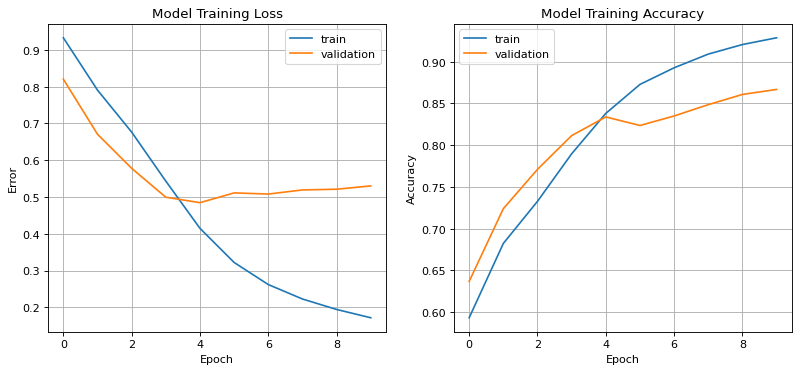

In [63]:
# Define a function to plot the loss curve
def plotLoss(h, name):
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='validation')
    plt.title('{0} Training Loss'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

# Plot the Accuracy curve
def plotAccuracy(h, name):
    plt.plot(h.history['Accuracy'], label='train')
    plt.plot(h.history['val_Accuracy'], label='validation')
    plt.title('{0} Training Accuracy'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Define the sub-plot size
nCols = 2
nRows = 1

# Prepare the Loss Plots
plt.figure(figsize=(nCols * 6, nRows * 5), dpi=80)

# Plot the Loss
plt.subplot(nRows, nCols, 1)
plotLoss(history, 'Model')

# Plot the Accuracy
plt.subplot(nRows, nCols, 2)
plotAccuracy(history, 'Model')

# Draw the plots
plt.show()



### Evaluate the Model

In [64]:
# Evaluate the Model
loss, accuracy, recall = model.evaluate(X_test, y_test, verbose=1)

1207/1207 [==============================] - 9s 7ms/step - loss: 0.5554 - Accuracy: 0.8623 - recall: 0.8473


### Classification Report

In [65]:
# Evaluate the model
y_pred = model.predict(X_test)

# Prepare the arrays
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Print the Classification Report
target_names = ['negative', 'neutral', 'positive']
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=target_names, zero_division=1))

1207/1207 [==============================] - 9s 7ms/step
Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.84      0.82      9715
     neutral       0.60      0.73      0.66      3452
    positive       0.93      0.89      0.91     25457

    accuracy                           0.86     38624
   macro avg       0.78      0.82      0.80     38624
weighted avg       0.87      0.86      0.87     38624



### Confusion Matrix

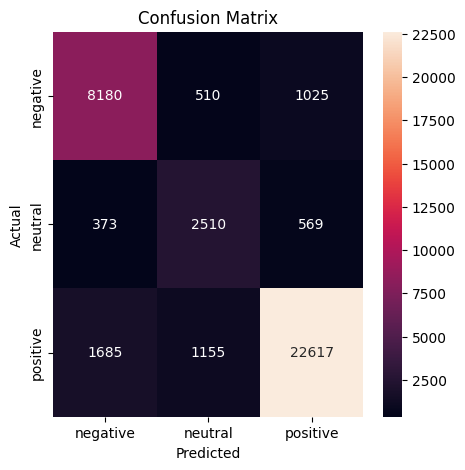

In [66]:
# Plot the Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 8. Discussion and conclusions

Instructions: Write

- What settings and models were tested before the best model was found
    - What where the results of these experiments 
- Summary of  
    - What was your best model and its settings 
    - What was the final achieved performance 
- What are your main observations and learning points
- Discussion how the model could be improved in future 

**Note:** Remember to evaluate the final metrics using the test set. 
